---
<div style="background-color: #c1f2a5">


# PS12

In this problem set, we are going to learn to navigate a simple maze.
    
# Instructions



Remember to do your problem set in Python 3. Fill in `#YOUR CODE HERE`.

Unless we specify otherwise, make sure: 
- that all plots are scaled in such a way that you can see what is going on (while still respecting specific plotting instructions) 
- that the general patterns are fairly represented.
- to label all x- and y-axes, and to include a title.
    
**Test cases are here to help you debug your code, but passing them successfully is not a guarantee that your code is correct.**
    
</div>

In [9]:
import numpy as np
import matplotlib.pyplot as plt

We are going to learn to navigate a simple maze. In this maze, you have to make two successive left-right decisions (0 or 1). The first takes you from state $s=0$ to states $s=1$ or $s=2$. The second decision takes you to states $3-6$, as pictured below.
![](Maze_JDS.png)
Taking a first step to S1 or S2 is costly ($r=-1$), but can get you to a position to get reward (states 3 and 6 give you 4, and 10 points respectively). Your goal is to gain as many points as possible, so you should learn to select right-right, which will give you a total cumulated reward of $-1+10 = 9$.

In this problem set, we will try a few different algorithms to learn this, and see how they behave differently. 

Below, we provide the reward function and the transition function.
- R[i,j] indicates what reward you obtain for selecting action j in state i
- T[i,j] indicates what state you will be in after you select action j in state i
Test it out to make sure it's right!

In [10]:
R = np.array([[-1,-1],[4,-1],[-1,10]])
T = np.array([[1,2],[3,4],[5,6]])

In [11]:
R

array([[-1, -1],
       [ 4, -1],
       [-1, 10]])

In [12]:
T

array([[1, 2],
       [3, 4],
       [5, 6]])

## Q1 - Softmax choice [HELP, 2pts]

In Q1, you will:
- write softmax function according to the specifications below
- use the softmax function to figure out how much cumulated reward in average if choosing randomly

As a reminder, here is the softmax equation: 
$$ P(a|s) = \frac{exp(\beta Q(s,a)}{\sum_i exp(\beta Q(s,a_i))}$$

To limit overflow issues, we recommend rewriting this equation like this:
$$ P(a|s) = \frac{1}{\sum_i exp(\beta [Q(s,a_i) - Q(s,a)])}$$

Check that your softmax function is correct with the tests, and report in gradescope the output of the next cell.

In that cell, we've provided code for an agent that doesn't learn, and just picks left or right based on their bias (which one they prefer). Make sure to read through the function, as it will help you code more intelligent agents later. 

In [13]:
def softmax(beta,Qs):
    """
    Returns softmax probability of a choice.
    
    Parameters
    ----------
    beta : real number
        The softmax inverse temperature parameter
    Qs: a (1,n) numpy array of values
            
    Returns
    -------
    a: an integer in [0,n]
        a choice made with probability defined by softmax(betaQs)
    """
    ps = [1/np.sum(np.exp(beta*(Qs-Q))) for Q in Qs]
    idx = np.arange(0, len(Qs))
    return np.random.choice(idx, p=ps)  # get the index of the Q with the highest p(a|s)

In [14]:
# add your own tests


In [15]:
"""Check softmax computes the correct values"""
from numpy.testing import assert_allclose

assert_allclose(softmax(100,np.array([0,1])), 1.0)
assert_allclose(softmax(100,np.array([0,1,0])), 1.0)
assert_allclose(softmax(100,np.array([0,0,1])), 2.0)
assert_allclose(softmax(100,np.array([1,0,0,0])), 0.0)

print("Success!")

Success!


In [16]:
def left_right_bias(beta,Qs,n_trials):
    """
    Returns average cumulated reward for a left-right bias agent.
    
    Parameters
    ----------
    beta : real number
        The softmax inverse temperature parameter
    Qs: a (1,n) numpy array of values
    n_trials: integer - number of trials to average over
            
    Returns
    -------
    float
        average cumulated reward
    """
    Cum_R = np.zeros(n_trials)
    for i in range(n_trials):
        # start at state 0
        initial_state = 0
        # make the first choice
        first_choice = softmax(beta,Qs)
        # see what reward that state gives, and what the next state is
        first_reward = R[initial_state,first_choice]
        next_state = T[initial_state,first_choice]
        # make a second choice
        second_choice = softmax(beta,Qs)
        # get reward
        second_reward =  R[next_state,second_choice]
        # store cumulated reward in this trial
        Cum_R[i] =first_reward + second_reward
    # return average cumulated reward.    
    return np.mean(Cum_R)
    
n_trials = 10000
beta = 0
Qs = np.zeros(2)
print('Random choice leads to average cumulated reward of: '+str(np.around(left_right_bias(beta,Qs,n_trials),decimals=2)))
beta = 5
Qs = np.array([.8,.5])
print('Random left-biased choice leads to average cumulated reward of: '+str(np.around(left_right_bias(beta,Qs,n_trials),decimals=2)))
beta = 5
Qs = np.array([.5,.8])
print('Random right-biased choice leads to average cumulated reward of: '+str(np.around(left_right_bias(beta,Qs,n_trials),decimals=2)))
beta = 50
Qs = np.array([.5,.8])
print('Near-greedy right-biased choice leads to average cumulated reward of: '+str(np.around(left_right_bias(beta,Qs,n_trials),decimals=2)))
    


Random choice leads to average cumulated reward of: 2.02
Random left-biased choice leads to average cumulated reward of: 1.69
Random right-biased choice leads to average cumulated reward of: 5.53
Near-greedy right-biased choice leads to average cumulated reward of: 9.0


## Q2. SARSA 

Now, we're going to code an agent that actually learns the values of different choices. 
We'll use the SARSA equation:
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t))$$

If there's no next state/action (i.e. when the algorithm reaches the end of the maze in any of states 3-6), the equation is simply: 
$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha (r_t  - Q(s_t,a_t))$$


### Q2.1 SARSA Update [3 pts, HELP] 
Complete the `sarsa` function below that takes the learning rate parameter $\alpha$, the discount factor $\gamma$; the Q-value table (a (3,2) np array); as well as a sequence of two successive states, two successive actions, and two successive outcomes describing one path through the maze. The function should return the updated Q-value table for states 0,1,2 and actions 0,1.

Copy paste your code in gradescope (or upload a screenshot if it doesn't work).

In [18]:
def sarsa(alpha, gamma,Q,s,a,r):
    """
    Returns updated Q-table.
    
    Parameters
    ----------
    alpha : real number
        The learning rate parameter
    gamma : real number
        The discount parameter
    Q: a (3,2) numpy array of values for states (0,1,2) and actions (0,1)
            
    Returns
    -------
    Q: a (3,2) numpy array of updated values for states (0,1,2) and actions (0,1)
    """

    #YOUR CODE HERE 
    Q[s[0],a[0]] = Q[s[0],a[0]] + alpha*(r[0]+gamma*Q[s[1],a[1]]-Q[s[0],a[0]])
    Q[s[1],a[1]] = Q[s[1],a[1]] + alpha*(r[1]-Q[s[1],a[1]])
    return Q

In [19]:
# add test cases


In [20]:
"""Check sarsa computes the correct values"""
from numpy.testing import assert_allclose

s = np.array([0,1]).astype(int)
a = np.zeros(2).astype(int)
r = np.array([-1,4]).astype(int)

alpha = .1
gamma=.9
assert_allclose(sarsa(alpha, gamma,0.5*np.ones([3,2]),s,a,r), np.array([[0.395,0.5],[0.85,0.5],[0.5,0.5]]))
a = np.ones(2).astype(int)
assert_allclose(sarsa(alpha, gamma,0.5*np.ones([3,2]),s,a,r), np.array([[0.5,0.395],[0.5,0.85],[0.5,0.5]]))
s = np.array([0,2]).astype(int)
assert_allclose(sarsa(alpha, gamma,0.5*np.ones([3,2]),s,a,r), np.array([[0.5,0.395],[0.5,0.5],[0.5,0.85]]))
alpha = .2
assert_allclose(sarsa(alpha, gamma,0.5*np.ones([3,2]),s,a,r), np.array([[0.5,0.29],[0.5,0.5],[0.5,1.2]]))
Q= sarsa(alpha, gamma,0.5*np.ones([3,2]),s,a,r)
gamma=.75
assert_allclose(sarsa(alpha, gamma,Q,s,a,r), np.array([[0.5,0.212],[0.5,0.5],[0.5,1.76]]))

print("Success!")

Success!


### Q2.2 One trial SARSA [5 pts, SOLO] 

Now, use the `sarsa` function you wrote as well as the `softmax` function you wrote to complete the function `onetrial_sarsa` below. This function should navigate one path through the maze, and return the two choices and rewards experienced, as well as the updated Q-value. Hint: you can use the `left_right_bias` function as a model for walking through the maze. 

Upload the figure produced by the following cell. Make sure to try plotting multiple times, and to upload the most representative figure.

In [79]:
def onetrial_sarsa(parameters,Q,R,T):
    """
    Returns updated Q-table.
    
    Input
    ----------
    parameters : (1,3) numpy array
        model parameters (beta, alpha, gamma)
    Q: a (3,2) numpy array of values for states (0,1,2) and actions (0,1)
    R: reward function (3,2) numpy array
    T: transition function (3,2) numpay array
            
    Returns
    -------
    Q: (3,2) numpy array of updated Q-values
    a: a (1,2) numpy array of the sequence of two choices
    r: a (1,2) numpy array of the sequence of two rewards.
    """
    #YOUR CODE HERE
    
    s = [0, 0]
    a = [0, 0]
    r = [0, 0]
    
    # make the first choice
    a[0] = softmax(parameters[0], Q[s[0]]) # first choice
    # see what reward that state gives, and what the next state is
    r[0] = R[s[0],a[0]] # first reward
    s[1] = T[s[0],a[0]] # next state
    # make a second choice
    a[1] = softmax(parameters[0], Q[s[1]]) # second choice
    # get reward
    r[1] =  R[s[1],a[1]] # second reward

    Q = sarsa(parameters[1], parameters[2], Q, s, a, r)
    
    return Q, a, r

In [80]:
# add your own test cases



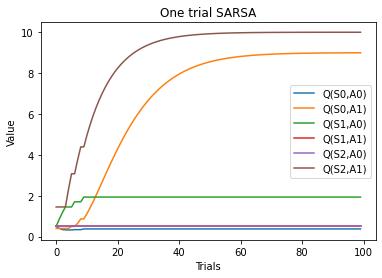

In [81]:
# Plotting the results 

R = np.array([[-1,-1],[4,-1],[-1,10]])
T = np.array([[1,2],[3,4],[5,6]])


nTrials = 100
Qs = np.empty((6,nTrials))
Q = np.array([[.5,.5],[.5,.5],[.5,.5]])
beta = 5
alpha = .1
gamma = 1
parameters = np.array([beta,alpha,gamma])

for t in range(nTrials):
    newQ,a,r=onetrial_sarsa(parameters,Q,R,T)
    Qs[:,t] = np.ndarray.flatten(newQ)
    
fig, axis = plt.subplots()
for i in range(6):
    axis.plot(Qs[i,:])
    
axis.legend(['Q(S0,A0)','Q(S0,A1)','Q(S1,A0)','Q(S1,A1)','Q(S2,A0)','Q(S2,A1)'])
plt.title('One trial SARSA')
plt.xlabel('Trials')
plt.ylabel('Value')
/
fig.savefig('PS12_Q2.png')

## Q3. Performance

Now, we'll run multiple simulations (100), and see what the final Q-values are. Use the provided parameter values (50 trials, beta=5, alpha=0.1, gamma=1). Make sure to re-initialize your Q-values for each simulation! 


### Q3.1 Plot final Q-values [5 pts, SOLO]
In three subplots, plot scatterplots of a) Q(s0,a0) vs. Q(s0,a1) b) Q(s0,a1) vs. Q(s1,a0) and c) Q(s0,a1) vs. Q(s2,a1).

Upload your graph to Bcourses.


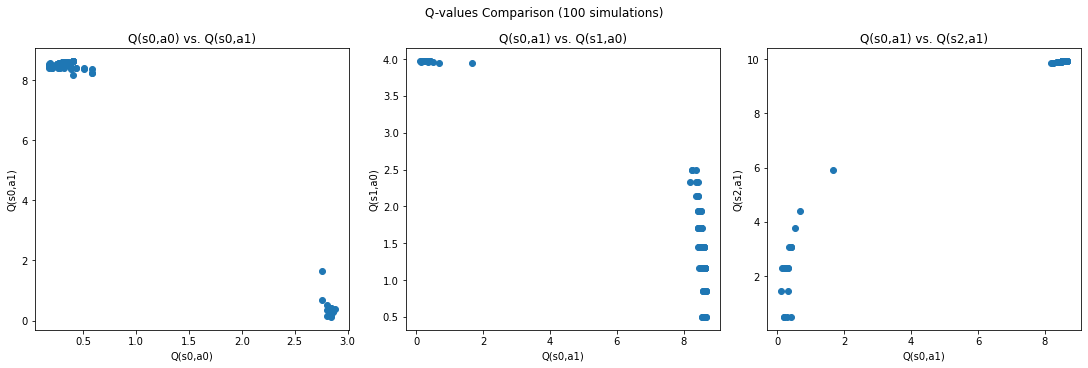

In [89]:
R = np.array([[-1,-1],[4,-1],[-1,10]])
T = np.array([[1,2],[3,4],[5,6]])


nTrials = 50
niterations = 100
Qs = np.empty((6,niterations))
beta = 5
alpha = .1
gamma = 1
parameters = np.array([beta,alpha,gamma])

## YOUR CODE HERE

for i in range(niterations):
    Q = np.array([[.5,.5],[.5,.5],[.5,.5]])
    for _ in range(nTrials):
        Q,a,r=onetrial_sarsa(parameters,Q,R,T)
    Qs[:,i] = np.ndarray.flatten(Q)


figure, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize = (15, 5), constrained_layout=True)
figure.suptitle("Q-values Comparison (100 simulations)")

# axis1: Q(s0,a0) vs. Q(s0,a1)
axis1.scatter(Qs[0], Qs[1])
axis1.set_title("Q(s0,a0) vs. Q(s0,a1)")
axis1.set_xlabel("Q(s0,a0)")
axis1.set_ylabel("Q(s0,a1)")

# axis2: Q(s0,a1) vs. Q(s1,a0) 
axis2.scatter(Qs[1], Qs[2])
axis2.set_title("Q(s0,a1) vs. Q(s1,a0)")
axis2.set_xlabel("Q(s0,a1)")
axis2.set_ylabel("Q(s1,a0)")

# axis3: Q(s0,a1) vs. Q(s2,a1)
axis3.scatter(Qs[1], Qs[5])
axis3.set_title("Q(s0,a1) vs. Q(s2,a1)")
axis3.set_xlabel("Q(s0,a1)")
axis3.set_ylabel("Q(s2,a1)")


figure.savefig('PS12_Q3.png')

In [90]:
Qs[1] < 4

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True, False, False, False, False,  True, False,
        True, False, False, False,  True, False, False, False,  True,
       False, False,  True, False, False,  True, False, False,  True,
       False])

In [91]:
Qs[1] > 4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True])

In [92]:
Qs[5] > 4

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False,  True,  True, False,  True,  True, False,
        True])


### Q3.2 Interpretation [3 pts, HELP]

If you got the previous function right, you should observe a small cluster of simulations that end up with different Q-values than the main cluster of simulations, at the same time for more than one state-action pair. Explain in gradescope what happened in those simulations.


## Q4. Parameter effects

In this part, we will explore the role of the various parameters on learning performance. To summarize performance, we will compute the average cumulated reward obtained at each trial (It should be a number between -2, the minimum reward over two steps, and 10-1=9, the maximum reward over two steps). 

Complete the function `cumulative_outcome` below.

In [ ]:
def cumulative_outcome(parameters,R,T,nTrials,niterations):
    """
    Returns average cumulative earnings.
    
    Input
    ----------
    parameters : (1,3) numpy array
        model parameters (beta, alpha, gamma)
    R: reward function (3,2) numpy array
    T: transition function (3,2) numpay array
    nTrials: integer (number of learning trials in an iteration)
    niterations: number of iterations of the simulation
            
    Returns
    -------
    average cumulated reward for two steps, over trials and simulations.
    """
    #YOUR CODE HERE


    

### Q4.1 Effect of beta [3 pts, SOLO]

to investigate the effect of beta on performance, use $\gamma = 0.5$. In one figure, plot performance as a function of beta value ranging 1-20 in increments of 2, for $\alpha = 0.1$ and $\alpha=0.3$. Add a legend. 

### Q4.2 Effect of beta - interpretation [4 pts, HELP]
What do you observe?  Explain how beta affects performance in both cases, and explain why, including any differences you may observe.

If your graph is wrong/you don't have a graph, you can still try to explain in general terms what effects $\beta$ could have on performance. 

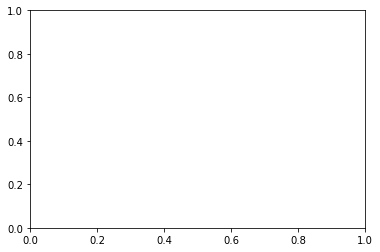

In [53]:


nTrials=20
niterations=1000

gamma=0.5


betaline=np.arange(1,20,2)
figure, axis = plt.subplots()

alpha=.1
R_beta = np.empty(len(betaline))

##YOUR CODE HERE

fig.savefig('PS12_Q4_2.png')

### Q4.3 Effect of alpha [SOLO, 3pts]

To investigate the effect of $\alpha$ on performance, use $\gamma = 5$. In one figure, plot performance as a function of alpha value ranging 0.05 to 1 in increments of .05, for $\beta = 1$, and $\beta = 5$. Add a legend. 

### Q4.4 Effect of alpha [HELP, 4pts]

What do you observe?  Explain how $\alpha$ affects performance in different cases, and explain why, including any differences you may observe.

If your graph is wrong/you don't have a graph, you can still try to explain in general terms what effects $\alpha$ could have on performance. 

In [ ]:


nTrials=20
niterations=1000

gamma=1
alphaline=np.arange(.05,1,.05)


##YOUR CODE HERE


fig.savefig('PS12_Q4_4.png')

## 5. Planning 
Now, we will try model-based reinforcement learning.
In this algorithm, the agent knows the reward function and the transition function. They use it to plan ahead: mentally walk through all possible paths in the maze, evaluate the cumulative reward for each path. They use this cumulative reward value between each path to choose one of the (four) possible paths, via a softmax function.


### 5.1 Implementing planning [3 pts, HELP]
Complete the `onetrial_planning` function below. Your function should a) compute the cumulative reward for each path of the tree and return it b) choose between the four possible paths using a softmax c) return the sequence of two actions and two rewards obtained.

Run your function 1000 times with $\beta=0.5$, $\gamma=0.5$, and plot as a bar plot the proportion of times each of the four paths was chosen. Upload your figure to bcourses.

In [ ]:
def onetrial_planning(parameters,R,T):
    """
    Runs one trial of planning.
    
    Input
    ----------
    parameters : (1,2) numpy array
        model parameters (beta, gamma)
    R: reward function (3,2) numpy array
    T: transition function (3,2) numpay array
            
    Returns
    -------
    Q: (1,4) numpy array of cumulative reward for each path
    a: (1,2) numpy array of the sequence of two choices selected
    r: (1,2) numpy array of the sequence of two rewards obtained.
    """
    # YOUR CODE HERE

In [ ]:
# add your own tests

In [ ]:

"""Check sarsa computes the correct values"""
from numpy.testing import assert_allclose

assert_allclose(onetrial_planning(np.array([1,1]),np.array([[-1,-1],[4,-1],[-1,10]]),T)[0], np.array([3,-2,-2,9]))
assert_allclose(onetrial_planning(np.array([1,.5]),np.array([[-1,-1],[4,-1],[-1,10]]),T)[0], np.array([1,-1.5,-1.5,4]))

print("Success!")

In [ ]:
# YOUR CODE HERE
    
fig.savefig('PS12_Q5_1.png')


### 5.2 Comparing planning to learning [5 pts, HELP]
We're going to compare Sarsa and Planning. Planning has more information, so it should perform better (i.e. get more cumulative reward). But it should also be more computationally expensive. We'll measure that by the time it takes the program to run.

Run both Sarsa and Planning for 1000 iterations of 100 trials each. In two subplots, plot a) the average cumulative reward for each model (x-axis), b) the duration of the computation for each model. [HINT: use the timeit package.]

Do the results match the predictions?

In [ ]:
import timeit

# YOUR CODE HERE
fig.savefig('PS12_Q5_2.png')

---
<div style="background-color: #c1f2a5">

# Submission

When you're done with your problem set, do the following:
- Upload your answers in Gradescope's PS12.

- Convert your Jupyter Notebook into a `.py` file by doing so:    
    
</div>


<center>    
  <img src="https://www.dropbox.com/s/7s189m4dsvu5j65/instruction.png?dl=1" width="300"/>
</center>

<div style="background-color: #c1f2a5">
    
- Submit the `.py` file you just created in Gradescope's PS5-code.
    
</div>        




</div>

</div>
